# Modern Portfolio Theorey Implementation

The Modern Portfolio Theorey (MPT / Proposed by Harry Markowitz - 1952) aims to create an optimal portfolio by balancing expected returns and risk. It does so by considering:

1. Expected Returns: The mean returns of the individual assets.

2. Risk: measured by the variance or standard deviation of returns.

3. Covariance: The correlation between the returns of different assets.

The key output of the Markowitz model is the efficient frontier, which shows the set of optimal portfolios offering the highest expected return for a given level of risk.

We will find the optimal portfolio using two approaches - <b> scipy.minimize and bayesian optimisation </b> and compare them

## Table of Contents

[1. Set Up Environment](#1) 

[2. Load and Prep Data](#2)
- Sanity Checking
- Addressing Missing Data
- Changing Data Frequency

[3. Evaluate stock performance](#3)   
- Annual Returns, Volatility of Return, Sharpe Ratio, Max Drawdown
- Alpha and Beta Values

[4. Compute Covariance Matrix of Returns](#4) 
- Check for factorability

[5. Markowitz Model](#5)

[6. Generate Efficient Frontier Data](#6)

[7. Plot Efficient Frontier](#7)

[8. Solving for Maximum Sharpe Ratio Point using scipy minimize ](#8)
- Formulation of the Optimization Problem for Maximizing Sharpe Ratio
- Show on Efficient Frontier

[9. Optimizing the portfolio using Bayesian Optimisation ](#9)
- Find Optimal Portfolio using bayesopt and plot it on Efficient Frontier
- Summary - scipy minimize vs Bayesian Optimization for finding optimal portfolio
    
[10. Conducting Back-Tests](#10)
- Buy-and-Hold strategy

[11. Interpreting Output Recommendations](#11)
    
[12. Future Directions ](#12)

[References ](#13)

## Step 1. Setup <a id="1"></a>

In [76]:
# Imports

import os
import csv
import numpy as np
import pandas as pd

!pip install factor-analyzer 
!pip install bayesian-optimization
# To identify underlying factors that influence the performance of different stocks
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity 
from factor_analyzer.factor_analyzer import calculate_kmo

from bayes_opt import BayesianOptimization

#for plotting
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

from scipy.optimize import minimize #for solving optmization
from sklearn.linear_model import LinearRegression #for solving linear regression

In [77]:
# Initialize data dir path and filenames used 
stock_dir = './Data/Stock' # Define the path to the Stock directory
sample_stk_file_name = './Data/Stock/AZN Historical Data.csv' # Define the filpath path for sample Stock 
ftse100_data_file_name = './Data/FTSE 100 Historical Price Data.csv'
gilt3m_data_file_name = './Data/United Kingdom 3-Month Bond Yield Historical Data.csv'
gilt6m_data_file_name = './Data/United Kingdom 6-Month Bond Yield Historical Data.csv'
gilt3m_wsj_data_file_name = './Data/WSJ_TMBMKGB-03Y_HistoricalPrices.csv'

In [78]:
# Initialize the start and end date for the data 
start_date = '2021-04-26'
end_date   = '2024-05-24'

start_date_train = '2021-04-26'
end_date_train   = '2024-05-24'

# weekly risk-free rate / calculated assuming 3m gilt gives 3% annualized return
hardcoded_rf_weekly = 0.000568600096428673  

## Step 2. Load and Prep Data <a id="2"></a>

### Load Chosen UK Stock Data <a id="2.1"></a>

The dataset used in this notebook is downloaded from https://uk.investing.com/ 

Stock Data for each of the stocks is in a seperate file and each file has the following columns: 

"Date","Price","Open","High","Low","Vol.","Change %" 

The first column corresponds to date information. 

The last column is the stock returns information.

The dataset ranges from 24th Apr 2021 to 24th May 2024;

The return data are holding period returns (in daily frequency). 

In [79]:
# Load Stock Return for a Sample Dataset 
df = pd.read_csv(sample_stk_file_name, low_memory=False, index_col=0 ) # set the first column (date) as index
df.index=pd.to_datetime(df.index, dayfirst=True) # set index (i.e. date) as a datetime object
display(df)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2024-05-24,"12,296.0","12,334.0","12,362.0","12,250.0",917.48K,-0.87%
2024-05-23,"12,404.0","12,330.0","12,450.0","12,264.0",1.44M,0.36%
2024-05-22,"12,360.0","12,358.0","12,440.0","12,255.2",1.79M,-0.03%
2024-05-21,"12,364.0","12,150.0","12,438.0","12,130.0",2.15M,2.22%
2024-05-20,"12,096.0","12,090.0","12,118.0","12,038.0",1.53M,-0.12%
...,...,...,...,...,...,...
2021-04-30,"7,715.0","7,519.0","7,867.0","7,502.0",3.37M,4.28%
2021-04-29,"7,398.0","7,494.0","7,556.0","7,392.0",1.91M,-1.45%
2021-04-28,"7,507.0","7,543.0","7,619.0","7,507.0",1.79M,-0.71%


In [80]:
# Initialize an empty dictionary to store dataframes
dataframes = {}

# Loop through each file in the Stock directory
for filename in os.listdir(stock_dir):
    if filename.endswith('Historical Data.csv'):
        # Extract the stock symbol from the filename (first word before space)
        stock_symbol = filename.split()[0]
        
        # Construct the full file path
        file_path = os.path.join(stock_dir, filename)
        
        # Read the file into a dataframe
        df = pd.read_csv(file_path, usecols=['Date', 'Change %'], low_memory=False, index_col=0)
        
        # Convert the index to datetime
        df.index = pd.to_datetime(df.index, dayfirst=True)
        
        # Extract the 'Change %' column, remove the '%' sign and convert to float
        df['Change %'] = df['Change %'].str.replace('%', '').astype(float) / 100
        
        # Create a new dataframe with 'Date' and 'Change %'
        temp_df = df[['Change %']].copy()
        
        # Rename the 'Change %' column to the stock symbol
        temp_df.rename(columns={'Change %': stock_symbol}, inplace=True)
        
        # Store the dataframe in the dictionary
        dataframes[stock_symbol] = temp_df

# Concatenate all dataframes on the date index
df = pd.concat(dataframes.values(), axis=1)

# Display the final dataframe
print(df)

               AZN    ULVR     DGE     VOD     RKT      BP    LLOY     CNA  \
Date                                                                         
2024-05-24 -0.0087 -0.0037 -0.0061 -0.0092 -0.0065  0.0009 -0.0176 -0.0191   
2024-05-23  0.0036  0.0087 -0.0131 -0.0151 -0.0052  0.0018 -0.0106 -0.0231   
2024-05-22 -0.0003 -0.0007 -0.0022  0.0011 -0.0163 -0.0185  0.0036 -0.0054   
2024-05-21  0.0222 -0.0016 -0.0152 -0.0249  0.0004 -0.0009 -0.0004  0.0130   
2024-05-20 -0.0012 -0.0072 -0.0023 -0.0003 -0.0124 -0.0001  0.0122  0.0114   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2021-04-30  0.0428  0.0044 -0.0061  0.0097  0.0095  0.0033 -0.0004  0.0107   
2021-04-29 -0.0145  0.0332  0.0069  0.0025  0.0098 -0.0082  0.0078  0.0105   
2021-04-28 -0.0071  0.0062  0.0059  0.0007 -0.0392  0.0312  0.0351  0.0221   
2021-04-27  0.0041 -0.0082  0.0044  0.0052 -0.0051 -0.0042  0.0160 -0.0142   
2021-04-26 -0.0045 -0.0067 -0.0244  0.0057 -0.0051  0.0152  0.00

In [81]:
# Print the total number of stocks and stock names/symbols included in the dataset
print('There are a total of', len(df.columns),'stocks included in this datafile.') 
print('The stocks included in this datafile are:')
for name in df.columns: print(name)

There are a total of 13 stocks included in this datafile.
The stocks included in this datafile are:
AZN
ULVR
DGE
VOD
RKT
BP
LLOY
CNA
NG
GSK
HSBA
BATS
PRU


In [82]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
AZN,777.0,0.000733,0.014660,-0.0800,-0.0065,0.0009,0.0087,0.0615
ULVR,777.0,0.000126,0.011739,-0.0697,-0.0056,0.0000,0.0058,0.0943
DGE,777.0,-0.000182,0.012485,-0.1217,-0.0063,0.0003,0.0067,0.0595
VOD,777.0,-0.000639,0.016019,-0.0891,-0.0093,-0.0004,0.0086,0.0569
RKT,777.0,-0.000425,0.014309,-0.1458,-0.0062,0.0003,0.0065,0.0594
BP,777.0,0.000816,0.018421,-0.0862,-0.0089,0.0010,0.0111,0.0795
LLOY,777.0,0.000473,0.017282,-0.1083,-0.0085,0.0008,0.0100,0.0815
CNA,777.0,0.001376,0.018321,-0.0724,-0.0089,0.0021,0.0120,0.0754
NG,777.0,0.000164,0.012206,-0.1086,-0.0060,0.0009,0.0067,0.0456
GSK,777.0,0.000427,0.012566,-0.1006,-0.0059,0.0007,0.0070,0.0754


### Load FTSE100 Data <a id="2.2"></a>

In [83]:
# Load Stock Return dataset 
ftse100 = pd.read_csv(ftse100_data_file_name, usecols=['Date', 'Change %'], low_memory=False, index_col=0 ) # set the first column (date) as index
# Extract the 'Change %' column, remove the '%' sign and convert to float
ftse100['Change %'] = ftse100['Change %'].str.replace('%', '').astype(float) / 100
ftse100.index=pd.to_datetime(ftse100.index, dayfirst=True) # set index (i.e. date) as a datetime object
display(ftse100)

,Change %
Date,
2024-05-24,-0.0026
2024-05-23,-0.0037
2024-05-22,-0.0055
2024-05-21,-0.0009
2024-05-20,0.0005
...,...
2021-04-30,0.0012
2021-04-29,-0.0003
2021-04-28,0.0027


### Load 3M Gilt Data (Risk Free Return) <a id="2.3"></a>

In [84]:
# Load Stock Return dataset 
gilt_3m = pd.read_csv(gilt3m_data_file_name, usecols=['Date', 'Change %'], low_memory=False, index_col=0 ) # set the first column (date) as index
# Extract the 'Change %' column, remove the '%' sign and convert to float
gilt_3m['Change %'] = gilt_3m['Change %'].str.replace('%', '') 
gilt_3m['Change %'] = gilt_3m['Change %'].str.replace(',', '')
gilt_3m['Change %'] = gilt_3m['Change %'].astype(float) / 100
gilt_3m.index=pd.to_datetime(gilt_3m.index, dayfirst=True) # set index (i.e. date) as a datetime object
display(gilt_3m)

,Change %
Date,
2024-05-24,-0.0011
2024-05-23,0.0032
2024-05-22,0.0126
2024-05-21,0.0006
2024-05-20,-0.0025
...,...
2021-04-30,-0.0533
2021-04-29,0.1364
2021-04-28,-0.0435


As can be seen above there are difference in the dates between the risk free return data vs ftse/stock data.  
When we convert the daily returns data to weekly data the above differences will go away. 

### Do Sanity Checks <a id="2.4"></a>

In [85]:
# For Stock Data

In [86]:
# Display a brief summary of the dataset 
print("\nSTK Data from Investing.com")
display(df.describe().T)
print("\nFTSE100 Data from Investing.com")
display(ftse100.describe().T)
print("\n3M Gilt Data from Investing.com")
display(gilt_3m.describe().T)


STK Data from Investing.com


,count,mean,std,min,25%,50%,75%,max
AZN,777.0,0.000733,0.014660,-0.0800,-0.0065,0.0009,0.0087,0.0615
ULVR,777.0,0.000126,0.011739,-0.0697,-0.0056,0.0000,0.0058,0.0943
DGE,777.0,-0.000182,0.012485,-0.1217,-0.0063,0.0003,0.0067,0.0595
VOD,777.0,-0.000639,0.016019,-0.0891,-0.0093,-0.0004,0.0086,0.0569
RKT,777.0,-0.000425,0.014309,-0.1458,-0.0062,0.0003,0.0065,0.0594
BP,777.0,0.000816,0.018421,-0.0862,-0.0089,0.0010,0.0111,0.0795
LLOY,777.0,0.000473,0.017282,-0.1083,-0.0085,0.0008,0.0100,0.0815
CNA,777.0,0.001376,0.018321,-0.0724,-0.0089,0.0021,0.0120,0.0754
NG,777.0,0.000164,0.012206,-0.1086,-0.0060,0.0009,0.0067,0.0456
GSK,777.0,0.000427,0.012566,-0.1006,-0.0059,0.0007,0.0070,0.0754



FTSE100 Data from Investing.com


,count,mean,std,min,25%,50%,75%,max
Change %,777.0,0.000266,0.008291,-0.0388,-0.0037,0.0007,0.0044,0.0391



3M Gilt Data from Investing.com


,count,mean,std,min,25%,50%,75%,max
Change %,803.0,0.074956,1.095298,-0.96,-0.00775,0.0004,0.01205,25.5


In [87]:
# Check if STK, FTSE and Gilt Data is present for the initialized date ranges 

In [88]:
# Ensure start_date and end_date are in datetime format
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Function to check if data exists within the date range for a given dataframe
def check_date_range(df, start_date, end_date):
    # Ensure the dataframe index is in datetime format
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Check if data exists within the date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    return df.loc[mask].empty == False

# Assuming df, ftse100, and gilt_3m are already defined and loaded

# Check if data exists within the specified date range for each dataframe
data_exists_df = check_date_range(df, start_date, end_date)
data_exists_ftse100 = check_date_range(ftse100, start_date, end_date)
data_exists_gilt_3m = check_date_range(gilt_3m, start_date, end_date)

# Print results
print(f"Data exists in 'df' between {start_date.date()} and {end_date.date()}: {data_exists_df}")
print(f"Data exists in 'ftse100' between {start_date.date()} and {end_date.date()}: {data_exists_ftse100}")
print(f"Data exists in 'gilt_3m' between {start_date.date()} and {end_date.date()}: {data_exists_gilt_3m}")

Data exists in 'df' between 2021-04-26 and 2024-05-24: True
Data exists in 'ftse100' between 2021-04-26 and 2024-05-24: True
Data exists in 'gilt_3m' between 2021-04-26 and 2024-05-24: True


### Address Missing Data <a id="2.5"></a>

### Apply transformation <a id="2.6"></a>

In [89]:
# Convert daily return data to weekly return
df_week = (df+1).resample('W').prod() - 1
df_week = df_week.drop(df_week.index[[-1]]) #manually remove the returns data for the last week
display(df_week.describe().T)

,count,mean,std,min,25%,50%,75%,max
AZN,160.0,0.003403,0.030412,-0.103355,-0.013434,0.005254,0.020015,0.096858
ULVR,160.0,0.000575,0.023221,-0.087807,-0.011652,0.000544,0.014802,0.084445
DGE,160.0,-0.000684,0.026010,-0.107443,-0.015796,0.002522,0.013496,0.108924
VOD,160.0,-0.002801,0.035298,-0.094111,-0.022856,-0.003617,0.017021,0.112244
RKT,160.0,-0.001809,0.031705,-0.131238,-0.016648,0.001815,0.015081,0.102690
BP,160.0,0.003983,0.038472,-0.132617,-0.017772,-0.000049,0.027445,0.152056
LLOY,160.0,0.002266,0.034989,-0.133980,-0.016922,-0.001977,0.027886,0.105365
CNA,160.0,0.006935,0.042864,-0.124030,-0.020637,0.007714,0.034926,0.144624
NG,160.0,0.001725,0.024104,-0.080914,-0.010565,0.003066,0.018195,0.054193
GSK,160.0,0.002061,0.027072,-0.130249,-0.014828,0.001455,0.017389,0.073668


In [90]:
# Convert daily return data to weekly return
ftse100_week = (ftse100+1).resample('W').prod() - 1
ftse100_week = ftse100_week.drop(ftse100_week.index[[-1]]) #manually remove the returns data for the last week
display(ftse100_week)

,Change %
Date,
2021-05-02,0.004496
2021-05-09,0.022955
2021-05-16,-0.012054
2021-05-23,-0.003516
2021-05-30,0.000683
...,...
2024-04-21,-0.012512
2024-04-28,0.030792
2024-05-05,0.009104


In [91]:
# Convert daily return data to weekly return
gilt_3m_week = (gilt_3m+1).resample('W').prod() - 1
gilt_3m_week = gilt_3m_week.drop(gilt_3m_week.index[[-1]]) #manually remove the returns data for the last week
display(gilt_3m_week)

,Change %
Date,
2021-05-02,0.543623
2021-05-09,-0.000027
2021-05-16,0.000044
2021-05-23,-0.169082
2021-05-30,0.355783
...,...
2024-04-21,0.001677
2024-04-28,0.004192
2024-05-05,-0.004108


## Step 3. Evaluate stock performance <a id="3"></a>

### Find the Returns (Annual), Volatility of Return, Sharpe Ratio, Max Drawdown <a id="3.1"></a>

In [92]:
Freq = 52 # frequency factor (given weekly data, it is 52)

# Functions for annualizing returns and standard deviation
def ann_ret(x):
    return (x+1)**Freq-1
def ann_std(x):
    return x*np.sqrt(Freq)

# Function used to find the Annualized geometric mean of x [note: x is weekly data]
def ann_geo_mean(x):
    n = len(x)
    return np.exp(np.sum(np.log(1+x)) * Freq / n) - 1

# Function used to find the Annualized Sharpe Ratio of x
def ann_sr(x, rf):    
    n = len(x)
    ret_expected = np.sum(x-rf)/n
    ret_avg = np.sum(x)/n
    std_dev = np.sqrt( np.sum( (x - ret_avg)**2 ) / n )
    annu_ret_expected = (ret_expected+1)**Freq-1
    annu_std_dev = std_dev * np.sqrt(Freq)
    return annu_ret_expected/annu_std_dev

# Function used to find the Maximum drawdown
def mdd(x):
    wealth = (x+1).cumprod() #x is a return vector
    cummax = wealth.cummax() #determine cumulative maximum value
    drawdown = wealth/cummax - 1 #calculate drawdown vector
    return drawdown.min()

In [93]:
# Output summary statistics information:
# Calculate and show the Mean, Geometric Mean, and Standard Deviation, Sharpe Ratio, Maximum Drawdown (with 2 decimals)
n_dec = 2
SumStat = pd.DataFrame(index = df_week.columns)
SumStat['Geo Mean(Annu,%)'] = np.round( df_week.apply(ann_geo_mean)*100, n_dec)
SumStat['Volatility(Annu,%)'] = np.round( ann_std(df_week.std())*100 , n_dec)
#SumStat['Sharpe Ratio (Annu)'] = np.round( df_week.apply(ann_sr, rf=gilt_3m_week['Change %']) , n_dec)
SumStat['Sharpe Ratio (Annu)'] = np.round( df_week.apply(ann_sr, rf=hardcoded_rf_weekly) , n_dec)
SumStat['Max Drawdown(%)'] = np.round(df_week.apply(mdd)*100, n_dec)
display(SumStat)

,"Geo Mean(Annu,%)","Volatility(Annu,%)",Sharpe Ratio (Annu),Max Drawdown(%)
AZN,16.53,21.93,0.73,-19.89
ULVR,1.61,16.75,0.00,-22.25
DGE,-5.18,18.76,-0.34,-32.67
VOD,-16.31,25.45,-0.63,-55.57
RKT,-11.38,22.86,-0.51,-37.60
BP,18.37,27.74,0.70,-20.38
LLOY,8.97,25.23,0.37,-27.67
CNA,36.69,30.91,1.27,-26.90
NG,7.74,17.38,0.36,-28.90
GSK,9.20,19.52,0.41,-28.03


Geo Mean (Annu,%): The geometric mean annual return, representing the average rate of return per year, compounded annually.

Volatility (Annu,%): The annualized standard deviation of returns, indicating the degree of variation in the asset's price over a year.

Sharpe Ratio (Annu): A measure of risk-adjusted return, calculated as the ratio of excess return (over the risk-free rate) to the standard deviation of the return.

Max Drawdown (%): The maximum observed loss from a peak to a trough in the asset's value, expressed as a percentage.


### Summary statistics

The above table presents key performance metrics for a selection of stocks, including Geo Mean (Annualized %), Volatility (Annualized %), Sharpe Ratio (Annualized), and Maximum Drawdown (%). Here's a summary conclusion based on these metrics:

1. High Performers:

    Centrica (CNA): Exhibits the highest annualized geometric mean return (36.69%) and the highest Sharpe Ratio (1.27), indicating strong performance with a high return relative to risk. However, it also has a relatively high volatility (30.91%) and a significant maximum drawdown (-26.90%).

    BP (BP): Shows a strong annualized return (18.37%) and a good Sharpe Ratio (0.70), but also high volatility (27.74%) and moderate maximum drawdown (-20.38%).

2. Moderate Performers:

    AstraZeneca (AZN): Offers a solid annualized return (16.53%) with moderate volatility (21.93%) and a reasonable Sharpe Ratio (0.73). It has a controlled maximum drawdown (-19.89%).

    HSBC (HSBA): Provides a good annualized return (17.97%) and a Sharpe Ratio (0.72) with relatively high volatility (25.24%) and a moderate maximum drawdown (-22.06%).

    Lloyds (LLOY) and GlaxoSmithKline (GSK): Both have moderate returns (8.97% and 9.20%, respectively) with acceptable volatility levels and modest Sharpe Ratios, indicating stable performance.

3. Low Performers:

    Unilever (ULVR): Shows minimal return (1.61%) and a zero Sharpe Ratio, indicating it offers almost no reward relative to its risk, combined with a considerable maximum drawdown (-22.25%).

    National Grid (NG): Has a modest return (7.74%) with low volatility (17.38%) and a low Sharpe Ratio (0.36), but a notable maximum drawdown (-28.90%).


4. Negative Performers:

    Diageo (DGE), Vodafone (VOD), Reckitt Benckiser (RKT), British American Tobacco (BATS), and Prudential (PRU): All exhibit negative annualized returns, high volatility, and negative Sharpe Ratios, indicating poor performance with significant risks. These stocks also suffer from high maximum drawdowns, highlighting their vulnerability to large losses.

Conclusion

Overall, stocks like CNA and BP emerge as strong performers with high returns and reasonable Sharpe Ratios, despite their higher volatility. AZN and HSBA also show solid performance with balanced risk-return profiles. On the other hand, stocks like VOD, PRU, and RKT show poor performance with high risk and substantial losses, making them less attractive. Maximum drawdown figures across the board indicate varying levels of risk, with some stocks experiencing significant declines from their peaks.

### Find the Alpha and Beta Values using LinearRegression <a id="3.2"></a>

In [94]:
# Function for performing linear regression and returning coefficient as well as intercept
def LR(X,y):
    reg = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))  # perform linear regression
    return reg.coef_,reg.intercept_

In [95]:
# Calculate and display alpha and beta for each stock

n_dec = 3 # rounding to this decimal places

# Get excess returns of the stocks and the market
#ex_ret = df_week.sub(gilt_3m_week['Change %'], axis=0)
#mkt_ex_ret = ftse100_week.sub(gilt_3m_week['Change %'], axis=0)
ex_ret = df_week.sub(hardcoded_rf_weekly, axis=0)
mkt_ex_ret = ftse100_week.sub(hardcoded_rf_weekly, axis=0)

# Count the number of NaNs in each column
nan_in_columns = mkt_ex_ret.isnull().sum()

print("Number of NaNs in each column:")
print(nan_in_columns)

# Calculate the alpha and beta for each stock
n = len(ex_ret.columns)
beta = np.zeros(n)
alpha = np.zeros(n)
for i in range(n):
    beta[i],alpha[i] = LR(mkt_ex_ret.values,ex_ret[ex_ret.columns[i]].values)
    
# Display the alpha and beta information
AlphaBeta = pd.DataFrame(index = df_week.columns)
AlphaBeta['Alpha(Annu,%)']  = np.round( ann_ret(alpha)*100, n_dec)
AlphaBeta['Beta']   = np.round(beta , n_dec)
display(AlphaBeta)

Number of NaNs in each column:
Change %    0
dtype: int64


,"Alpha(Annu,%)",Beta
AZN,11.777,0.887
ULVR,-2.306,0.584
DGE,-8.876,0.684
VOD,-19.123,0.903
RKT,-13.342,0.477
BP,13.892,1.167
LLOY,3.578,1.311
CNA,34.405,0.852
NG,3.483,0.638
GSK,5.295,0.642


A positive Alpha indicates that the investment has outperformed the market (benchmark), while a negative Alpha suggests underperformance.


A Beta of 1 indicates that the investment's price moves with the market. A Beta less than 1 means the investment is less volatile than the market, and a Beta greater than 1 indicates higher volatility than the market.


## Step 4. Compute Covariance Matrix of Returns <a id="4"></a>

In [96]:
# Calculate and output the covariance matrix for the stock returns
data_cov_mat = df_week.cov()
data_cov_mat_annu = data_cov_mat * Freq # Annualize the co-variance matrix
print("The Annualized Covariance matrix (for the weekly returns) is: ")
display(data_cov_mat_annu)

The Annualized Covariance matrix (for the weekly returns) is: 


,AZN,ULVR,DGE,VOD,RKT,BP,LLOY,CNA,NG,GSK,HSBA,BATS,PRU
AZN,0.048093,0.011259,0.011674,0.008668,0.013445,0.009052,0.007529,0.016568,0.014610,0.018558,0.012620,0.007859,0.008668
ULVR,0.011259,0.028040,0.011153,0.006457,0.016472,0.004574,0.009935,0.009486,0.008512,0.011960,0.010951,0.011486,0.008414
DGE,0.011674,0.011153,0.035180,0.007132,0.012674,-0.001253,0.009823,0.005573,0.009154,0.007429,0.007761,0.009541,0.012053
VOD,0.008668,0.006457,0.007132,0.064789,-0.001857,0.014827,0.018445,0.020057,0.013464,0.008530,0.027867,0.016472,0.026876
RKT,0.013445,0.016472,0.012674,-0.001857,0.052271,-0.006078,0.004025,0.007227,0.010873,0.012543,0.001049,0.007536,0.006969
BP,0.009052,0.004574,-0.001253,0.014827,-0.006078,0.076966,0.024802,0.024409,0.001529,0.009777,0.029226,0.011090,0.015384
LLOY,0.007529,0.009935,0.009823,0.018445,0.004025,0.024802,0.063659,0.019176,0.010755,0.004892,0.036732,0.011437,0.033214
CNA,0.016568,0.009486,0.005573,0.020057,0.007227,0.024409,0.019176,0.095540,0.014897,0.016554,0.011596,0.012150,0.020733
NG,0.014610,0.008512,0.009154,0.013464,0.010873,0.001529,0.010755,0.014897,0.030211,0.011407,0.006994,0.010710,0.012403
GSK,0.018558,0.011960,0.007429,0.008530,0.012543,0.009777,0.004892,0.016554,0.011407,0.038112,0.010104,0.010931,0.003586


### Check Factorability <a id="4.1"></a>

In [97]:
chi_square_value,p_value = calculate_bartlett_sphericity(df_week)
print("In this Bartlett ’s test, the p-value is:", p_value)
if (p_value < 0.05):
    print("The test was statistically significant; the observed correlation matrix is not an identity matrix.")

In this Bartlett ’s test, the p-value is: 5.670794674818095e-62
The test was statistically significant; the observed correlation matrix is not an identity matrix.


In [98]:
kmo_all,kmo_model = calculate_kmo(df_week)
print("In this KOM test, the overall KMO is:", kmo_model)
if (kmo_model > 0.6):
    print("Value of KMO is greater than 0.6; you can adequately perform factor analysis with the data.")

In this KOM test, the overall KMO is: 0.790520890165721
Value of KMO is greater than 0.6; you can adequately perform factor analysis with the data.


/Users/eugene/anaconda3/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


## Step 5. Markowitz Model <a id="5"></a>

### Formulate Markowitz Problem <a id="5.1"></a>

- Minimize the portfolio variance given:
    - the budget constraint, 
    - non-negativity contraint (all weight must be positive, i.e. no shorting),
    - return constraint (the expected return of the portfolio should be greater than or equal to a given number r-bar).

Objective:  $$ \text{min } w^T Q w$$

Constriants:

1) budget constraint: $$ \textbf{1}^T w = 1 $$
2) nonnegative constraint: $$w \geq 0$$
3) return constraint: $$\mu^T w \geq \bar{r}$$

where:
- $w$ = vector for weights (amount of investment)
- $Q$ = covariance matrix
- $\textbf{1}$ = vector of 1's
- $\mu$ is the vector for expected return 
- $\bar{r}$ is the target return

Notice that all we need from the data is the expected return and covariance matrix for solving the Markowitz Problem. We will assume the expected return follows the historical mean and the covariance matrix resembles the historical covariance. 

In [99]:
# Extract stock return, FTSE, and Gilt data for the given time period
ind = (df_week.index >= start_date_train)*(df_week.index <= end_date_train)
stock_train = df_week[ind].copy()
ftse100_train = ftse100_week[ind].copy()
gilt3m_train = gilt_3m_week[ind].copy()

In [100]:
# Get the mean and covariance matrix of the training data
data_train_mean = stock_train.mean()
data_train_cov_mat = stock_train.cov()

# Function to compute the expected return for the portfolio
def EReturn(w):
    EReturn = w @ data_train_mean
    return EReturn

# Function to compute the portfolio standard deviation
def PVol(w):
    pvar = w @ data_train_cov_mat @ w
    return np.sqrt(pvar)

# Function to solve for the optimal solution to the Markowitz Portfolio Optimization Problem 
# with specified target return r
def MarkPortOpt(r, silent = False):

    # Constraints
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint   
    def constraint2(w):
        return 1.0 - np.sum(w) # budget constraint
    def constraint3(w):
        return w # nonnegative constraint
    def constraint4(w):
        diff = EReturn(w) - r
        return diff # return constraint    
    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    cons = ([con1,con2,con3,con4])

    # Initial x0
    w0 = np.ones(len(stock_train.columns))

    # Solve the problem
    sol = minimize(PVol, w0, method='SLSQP',constraints=cons)
    
    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Markowitz Problem with r =  ", round(r*100,3), "%:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exit successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")
        
    return sol

In [101]:
# Find the solution given a specified target return r 
sol = MarkPortOpt(r = 0.001, silent = False)

Solution to the Markowitz Problem with r =   0.1 %:
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.01575689108714234
       x: [ 3.587e-02  1.511e-01 ...  9.006e-02  8.910e-03]
     nit: 13
     jac: [ 1.637e-02  1.547e-02 ...  1.568e-02  1.510e-02]
    nfev: 183
    njev: 13



## Step 6. Generate Efficient Frontier Data <a id="6"></a>

In [102]:
# Config # 

# Number of targeted returns (or r-bar) we want to set
numR = 16

# Setting target return r-bar
r_bar = np.array([i for i in range(numR-3)])*0.0003 + 0.002 #using same increment for the first several r-bars
r_bar = np.append(r_bar,np.array([0.00505,0.0051,0.00515])) #using different increments for the last several r-bars

In [103]:
# Print the number of target returns actually specified:
if (len(r_bar) != numR):
    numR = len(r_bar)
print("Number of targeted returns (or r-bar) specified is: ", numR)
print(r_bar)

Number of targeted returns (or r-bar) specified is:  16
[0.002   0.0023  0.0026  0.0029  0.0032  0.0035  0.0038  0.0041  0.0044
 0.0047  0.005   0.0053  0.0056  0.00505 0.0051  0.00515]


In [104]:
# Two lists to record the volatility and expected return for each portfilio 
port_vol = []
port_return = []

# A matrix storing the portfolio alloaction
alloc_r = np.zeros((len(stock_train.columns),numR))

# Solve the Markowitz problem for each r-bar and output the results
for i in range(numR):
    r = r_bar[i]
    print("* For the case r-bar = ", round(r*100,3), "%:")
    sol = MarkPortOpt(r, silent = True)
    
    if (not sol['success']): #check if the optimizer exit successfully
        print("NOTE: solution to this r-bar will be dropped!")
    else: #only keeping the r-bar that has sucessful optmization
        print(sol['message'])
        alloc_r[:,i] = sol['x']
        port_vol.append(sol['fun'])
        port_return.append(EReturn(sol['x']))
    print("")
    
port_vol = np.asarray(port_vol)
port_return = np.asarray(port_return)

num_rbar = len(port_vol) #update the number of r-bar recorded/kept
print("The number of recorded efficient frontier points is:", num_rbar)

* For the case r-bar =  0.2 %:
Optimization terminated successfully

* For the case r-bar =  0.23 %:
Optimization terminated successfully

* For the case r-bar =  0.26 %:
Optimization terminated successfully

* For the case r-bar =  0.29 %:
Optimization terminated successfully

* For the case r-bar =  0.32 %:
Optimization terminated successfully

* For the case r-bar =  0.35 %:
Optimization terminated successfully

* For the case r-bar =  0.38 %:
Optimization terminated successfully

* For the case r-bar =  0.41 %:
Optimization terminated successfully

* For the case r-bar =  0.44 %:
Optimization terminated successfully

* For the case r-bar =  0.47 %:
Optimization terminated successfully

* For the case r-bar =  0.5 %:
Optimization terminated successfully

* For the case r-bar =  0.53 %:
Optimization terminated successfully

* For the case r-bar =  0.56 %:
Optimization terminated successfully

* For the case r-bar =  0.505 %:
Optimization terminated successfully

* For the case r-bar 

In [105]:
# Display the optimal allocation for each specified target return
DF_Alloc_R = pd.DataFrame(alloc_r)
DF_Alloc_R.index = stock_train.columns
DF_Alloc_R.columns = [str(round(ann_ret(r)*100, 1))+"%" for r in r_bar]
DF_Alloc_R = DF_Alloc_R.loc[:,(DF_Alloc_R!=0).any(axis=0)] #drop the r-bar solution(s) that failed the opt. problem

print('Optimal allocation (in %) for specified (annualized) target return:')
display(np.round(DF_Alloc_R*100, 1)) #allocation in % and round (to the 1st decimal)

Optimal allocation (in %) for specified (annualized) target return:


,10.9%,12.7%,14.5%,16.3%,18.1%,19.9%,21.8%,23.7%,25.6%,27.6%,29.6%,31.6%,33.7%,29.9%,30.3%,30.6%
AZN,7.1,8.5,10.4,12.7,14.5,16.4,19.1,21.1,23.0,25.1,26.0,20.6,14.8,24.5,23.9,23.1
ULVR,15.5,15.4,14.5,12.4,10.6,7.8,3.4,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
DGE,12.9,11.3,8.8,5.7,2.2,0.2,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VOD,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
RKT,2.1,0.3,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
BP,12.0,12.3,12.5,12.4,12.0,12.1,11.6,12.3,11.0,11.2,9.9,8.6,6.1,10.9,9.9,9.6
LLOY,1.4,0.8,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0
CNA,6.6,8.4,10.6,13.1,15.7,18.6,21.8,25.3,30.6,35.2,41.1,50.0,59.0,42.4,44.0,45.5
NG,22.0,22.9,23.0,21.8,22.0,20.7,18.5,13.9,9.7,5.1,0.0,0.0,-0.0,0.0,0.0,-0.0
GSK,9.7,9.9,10.0,9.9,9.2,8.5,7.8,8.2,4.9,0.9,-0.0,0.0,-0.0,-0.0,0.0,0.0


## Step 7. Plot Efficient Frontier <a id="7"></a>

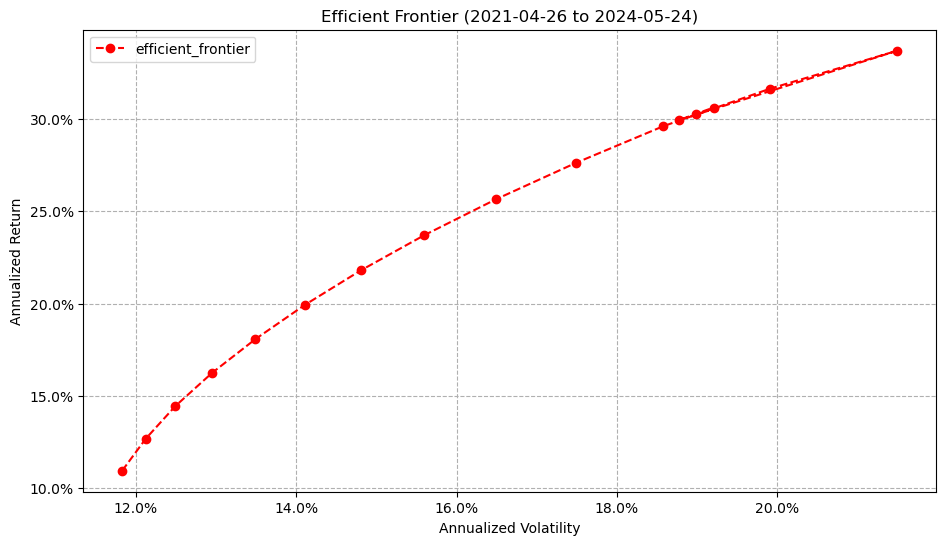

In [106]:
# Plotting efficient frontier
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='efficient_frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier ('+str(start_date_train)+' to '+str(end_date_train)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Step 8. Solving for Maximum Sharpe Ratio Point using scipy minimize <a id="8"></a>

### Formulate Optimization Problem for Maximizing Sharpe Ratio - minimize risk <a id="8.1"></a>

### Formulation of the Optimization Problem for Maximizing Sharpe Ratio:

Objective:  $$ \text{max }_{w \in \mathbb{R}^n} \frac{\mu^T w - r_{f}}{ \sqrt{w^T Q w}}$$

Constriants:

1) budget constraint: $$ \textbf{1}^T w = 1 $$
2) nonnegative constraint: $$w \geq 0$$

where:
- $w$ = vector for weights (amount of investment)
- $\mu$ is the vector for expected return 
- $r_{f}$ is the risk-free rate
- $Q$ = covariance matrix
- $\textbf{1}$ = vector of 1's

In [107]:
# Function to compute the annualized sharpe ratio for the portfolio given portfolio weight
# Note that it returns the -1 * Annualized Sharpe Ratio 
def AnnSR(w, data = stock_train, rf = hardcoded_rf_weekly):
    excess_ret = data @ w - rf 
    AnnSR = ann_ret(excess_ret.mean())/ann_std(PVol(w))
    return AnnSR


# Function to find the optimal portfolio that maximize the Sharpe ratio 
# Returns the optimal solution
def MaxSR(data = stock_train, rf = hardcoded_rf_weekly, silent = False):
    
    #Objective Function
    def SR(w):
        excess_ret = data @ w - rf 
        SR = (excess_ret.mean())/(PVol(w))
        return -SR
    
    n = len(data.columns)
    
    #Bounds
    bnds = tuple((0,1) for i in range(n)) # nonnegativity constraint

    # Constraints
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint   
    cons = {'type': 'eq', 'fun': constraint1}
    
    # Initial x0
    w0 = np.array(np.ones(n))
    
    # Solve the problem
    sol = minimize(SR, w0, method='SLSQP', bounds=bnds, constraints=cons)
    
    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Max Sharpe Ratio Problem is:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exist successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")
        
    return sol

In [108]:
sol['x'].shape

(13,)

In [109]:
# Find the optimal portfolio that maximize Sharpe Ratio
sol = MaxSR()
w_SR = sol['x'] #the portfolio weight with highest Sharpe Ratio

# Calculate the volatility and expected return for the optimal portfolio
opt_vol = PVol(sol['x'])
opt_return = EReturn(sol['x'])
sr = AnnSR(sol['x'])

# Print (annualized) return, volatiltiy and Sharpe ratio information
print("* The expected return (annualized) for the optimal portfolio is ", ann_ret(opt_return) )
print("* The volatility (annualized) for the optimal portfolio is ", ann_std(opt_vol) )
print("* The Sharpe ratio (annualized) for the optimal portfolio is ", sr)
print()

# Display the optimal allocation after adding in the allocation correspond to the max SR
DF_Alloc_R['maxSR'] = w_SR 
print('Optimal allocation (in %) for specified target return:')
DF_Alloc_R = DF_Alloc_R.loc[:,(DF_Alloc_R!=0).any(axis=0)] #drop the r-bar solution(s) that failed the opt. problem
display(np.round(DF_Alloc_R*100, 1)) #allocation in % and round (to the 1st decimal)

Solution to the Max Sharpe Ratio Problem is:
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.17210522093292321
       x: [ 2.397e-01  9.671e-17 ...  0.000e+00  0.000e+00]
     nit: 8
     jac: [-2.161e-02  2.500e-02 ...  6.451e-02  2.026e-01]
    nfev: 112
    njev: 8

* The expected return (annualized) for the optimal portfolio is  0.30186419167566103
* The volatility (annualized) for the optimal portfolio is  0.1892726331834607
* The Sharpe ratio (annualized) for the optimal portfolio is  1.3954145799304045

Optimal allocation (in %) for specified target return:


,10.9%,12.7%,14.5%,16.3%,18.1%,19.9%,21.8%,23.7%,25.6%,27.6%,29.6%,31.6%,33.7%,29.9%,30.3%,30.6%,maxSR
AZN,7.1,8.5,10.4,12.7,14.5,16.4,19.1,21.1,23.0,25.1,26.0,20.6,14.8,24.5,23.9,23.1,24.0
ULVR,15.5,15.4,14.5,12.4,10.6,7.8,3.4,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
DGE,12.9,11.3,8.8,5.7,2.2,0.2,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VOD,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
RKT,2.1,0.3,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
BP,12.0,12.3,12.5,12.4,12.0,12.1,11.6,12.3,11.0,11.2,9.9,8.6,6.1,10.9,9.9,9.6,9.8
LLOY,1.4,0.8,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
CNA,6.6,8.4,10.6,13.1,15.7,18.6,21.8,25.3,30.6,35.2,41.1,50.0,59.0,42.4,44.0,45.5,43.5
NG,22.0,22.9,23.0,21.8,22.0,20.7,18.5,13.9,9.7,5.1,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
GSK,9.7,9.9,10.0,9.9,9.2,8.5,7.8,8.2,4.9,0.9,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0


### Plot Efficient Frontier with max Sharpe ratio <a id="8.2"></a>

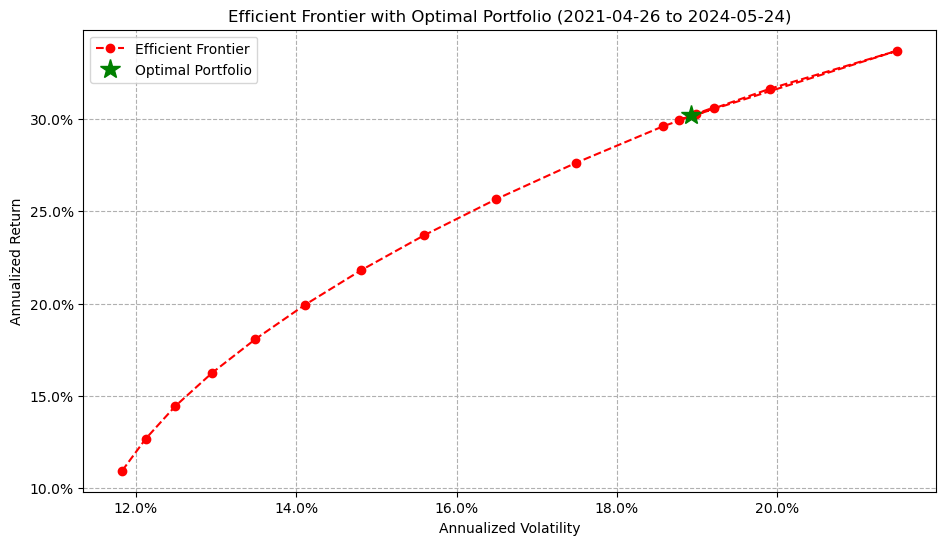

In [110]:
# Plotting efficient frontier and mark the portfolio with maximum Sharpe ratio
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='Efficient Frontier') #plot efficient frontier
plt.plot(ann_std(opt_vol), ann_ret(opt_return), 'g*', markersize=15, label='Optimal Portfolio') #plot max SR portfolio
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier with Optimal Portfolio ('+str(start_date_train)+' to '+str(end_date_train)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

# Step 9 Optimizing the portfolio using Bayesian Optimisation <a id="9"></a>

The objective function for Bayesian optimization should be defined based on what you aim to optimize. In the context of Modern Portfolio Theory, you might want to minimize risk (standard deviation) or maximize return.

In [111]:
mean_returns = stock_train.mean() 
cov_matrix = stock_train.cov()

# Function that calculates the portfolio return and risk assumes daily returns and annualizes them direclty using a factor of 252
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=hardcoded_rf_weekly):
    weights = np.array(weights)
    weights = weights.reshape(-1)
    opt_return = EReturn(weights)
    opt_vol = PVol(weights)
    sr = AnnSR(weights)    
    return opt_return, opt_vol, sr

#Objective Function
def sharpe_ratio(w, data = stock_train, rf = hardcoded_rf_weekly):
    excess_ret = data @ w - rf 
    SR = (excess_ret.mean())/(PVol(w))
    return SR

#Objective Function
def objective(**weights):
    weights = np.array(list(weights.values()))    
    #print("weights:",weights)
    weights /= np.sum(weights)
    #print("normalized weights:",weights)
    #_, _, sharpe = portfolio_performance(weights, mean_returns, cov_matrix
    return sharpe_ratio(weights)

In [112]:
num_points = 1

# A matrix storing the portfolio alloaction
alloc_r = np.zeros((len(stock_train.columns),num_points))

# Bounds for the optimizer (each weight between 0 and 1)
bounds = {f'w{i}': (0, 1) for i in range(len(stock_train.columns))}

# Function to optimize and store results
def optimize_portfolio(num_points):
    results = {'returns': [], 'volatility': [], 'sharpe': [], 'weights': []}
    
    for i in range(num_points):
        optimizer = BayesianOptimization(
            f=objective,
            pbounds=bounds,
            random_state=np.random.randint(1000),
            allow_duplicate_points=True,
            verbose=2
        )
        optimizer.maximize(init_points=13, n_iter=200)
        optimal_weights = optimizer.max['params']
        optimal_weights = np.array(list(optimal_weights.values()))
        optimal_weights /= np.sum(optimal_weights)  # Normalize weights
        returns, vol, sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix)        
        alloc_r[:,i] = optimal_weights
        results['returns'].append(returns)
        results['volatility'].append(vol)
        results['sharpe'].append(sharpe)
        results['weights'].append(optimal_weights)
        
    return results

# Calculate efficient frontier

results = optimize_portfolio(num_points)

|   iter    |  target   |    w0     |    w1     |    w10    |    w11    |    w12    |    w2     |    w3     |    w4     |    w5     |    w6     |    w7     |    w8     |    w9     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.092407  | 0.0727286 | 0.0649443 | 0.0635698 | 0.0048606 | 0.513328  | 0.917129  | 0.77129   | 0.694339  | 0.955197  | 0.455826  | 0.0290067 | 0.503877  | 0.116952  |
| 2         | 0.0398697 | 0.462103  | 0.463028  | 0.223338  | 0.743629  | 0.940115  | 0.807913  | 0.3041    | 0.945671  | 0.0547725 | 0.995215  | 0.184196  | 0.375764  | 0.691919  |
| 3         | 0.0539228 | 0.896375  | 0.977744  | 0.102083  | 0.692114  | 0.0818392 | 0.656826  | 0.564536  | 0.512599  | 0.0534157 | 0.21347   | 0.759905  | 0.436128  | 0.637893  |
| 4         | 0.0102925 | 0.0412012 | 0.612724  | 0.634594  | 0.127023  | 0.57007   | 0.25

In [113]:
weights = np.array(results['weights'])
weights = weights.reshape(-1)  

# Print (annualized) return, volatiltiy and Sharpe ratio information
print("* The expected return (annualized) for the optimal portfolio is ", ann_ret(EReturn(weights)) )
print("* The volatility (annualized) for the optimal portfolio is ", ann_std(PVol(weights)) )
print("* The Sharpe ratio (annualized) for the optimal portfolio is ", AnnSR(weights))
print()

* The expected return (annualized) for the optimal portfolio is  0.3019510984618399
* The volatility (annualized) for the optimal portfolio is  0.18932627366151
* The Sharpe ratio (annualized) for the optimal portfolio is  1.39546520046283



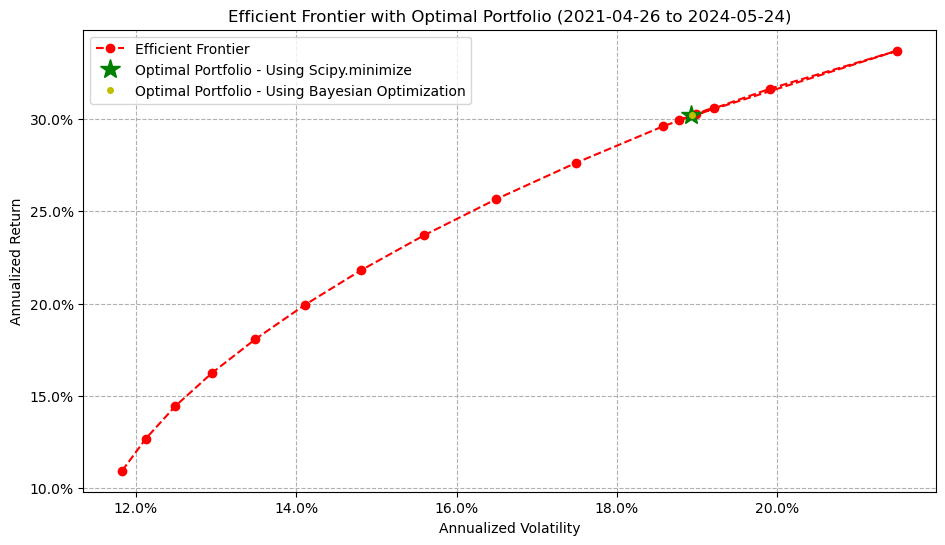

In [114]:
# Plotting efficient frontier and mark the portfolio with maximum Sharpe ratio
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='Efficient Frontier') #plot efficient frontier
plt.plot(ann_std(opt_vol), ann_ret(opt_return), 'g*', markersize=15, label='Optimal Portfolio - Using Scipy.minimize') #plot max SR portfolio
plt.plot(ann_std(PVol(weights)), ann_ret(EReturn(weights)), 'yo', markersize=4, label='Optimal Portfolio - Using Bayesian Optimization') #plot max SR portfolio
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier with Optimal Portfolio ('+str(start_date_train)+' to '+str(end_date_train)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

### Summary: `bayesopt.BayesianOptimization` vs. `scipy.optimize.minimize` for Portfolio Optimization

**`bayesopt.BayesianOptimization`:**
- **Complex Objective Functions**: Handles non-convex and noisy functions well without needing gradients.
- **Efficiency**: Requires fewer function evaluations and balances exploration and exploitation, often leading to global optima.
- **Constraints**: Can incorporate constraints using penalty terms, though this can be less straightforward.
- **Scalability**: Best for low to moderately high-dimensional problems due to the computational cost of updating the surrogate model.
- **Ease of Implementation**: Libraries like `bayes_opt` simplify implementation and offer flexibility with different acquisition functions.

**`scipy.optimize.minimize`:**
- **Complex Objective Functions**: Best for smooth, differentiable functions but may struggle with highly non-convex functions.
- **Efficiency**: Quick at finding local optima, but global optimization is not guaranteed.
- **Constraints**: Natively supports a variety of constraints and bounds, efficiently handled by methods like SLSQP.
- **Scalability**: Better suited for higher-dimensional problems, especially with gradient-based methods.
- **Ease of Implementation**: Part of the well-integrated SciPy library, offering various algorithms to suit different optimization needs.

## Step 10. Conducting Back-Tests <a id="10"></a>

When we construct the Markowitz problem, we use the expected return and covariance matrix as a given input; this in fact shows that we have made some assumptions regarding the returns of the stocks and that the resulting asset allocation is an idealized solution based on the assumptions.

Therefore, to better evaluate the performance of the portfolio, we will use real-world conditions and perform back-test(s) on the resulting asset allocation using actual historical returns. One might note that the asset allocation from the idealized efficient frontier may not be exactly on the efficient frontier due to skewness and kurtosis over the historical period.

In [115]:
# Trim dataset to have the specified start and end dates for the historical back test
stock_BT = df_week.copy()
ftse100_BT = ftse100.copy()
gilt_3m_BT = gilt_3m.copy()

### Buy-and-Hold Strategy <a id="9.1"></a>

In [116]:
# Functions to calculate the portfolio return for back-testing given portfolio weight
# Return the portfolio return over the full back-testing period
# Buy-and-hold strategy
def portRet_BH(w): 
    n = stock_BT.shape[0]
    PR = np.zeros(n) 
    X = w * 1 #initial wealth assume to be 1
    for i in range(n):
        W = (1+stock_BT.iloc[i]) @ X #wealth after each period
        PR[i] = (W - np.sum(X))/np.sum(X) #calculate and record portfolio return for that period
        X = (1+stock_BT.iloc[i]) * X #how much of the wealth is invested in each asset
    return PR

# Function to display the summary statistics of the back test results
# It takes in the portfolio returns dataframe and returns the mean and standard deviation of the portfolio returns
def DisplaySummary_BT(PR, n_dec = 2):
    col_names = PR.columns
    
    # Compute and display summary statistics for each portfolio
    print('Summary statistic of various allocations for the back test (from '+
          str(start_date_train)+' to '+str(end_date_train)+'):')
    PR_mean = PR.mean()
    PR_std = PR.std()
    BT = pd.DataFrame(index = col_names)
    BT['Geo Mean(Annu,%)'] = np.round( PR.apply(ann_geo_mean) *100, n_dec)
    BT['Std(Annu,%)'] = np.round( ann_std(PR.std()) *100, n_dec)
    BT['Sharpe Ratio (Annu)'] = np.round( PR.apply(ann_sr, rf=hardcoded_rf_weekly), n_dec)
    #BT['Sharpe Ratio (Annu)'] = np.round( PR.apply(ann_sr, rf=gilt_3m_BT['Change %']), n_dec)
    BT['Max Drawdown(%)'] = np.round(PR.apply(mdd)*100, n_dec)
    display(BT)
    
    return PR_mean,PR_std

In [117]:
# Add the equal weighted portfolio to our portfolio allocation dataframe
n_stocks = len(df_week.columns)
w_EQ = np.array(np.ones(n_stocks))/n_stocks
DF_Alloc_R['Equal'] = w_EQ
display(DF_Alloc_R)

,10.9%,12.7%,14.5%,16.3%,18.1%,19.9%,21.8%,23.7%,25.6%,27.6%,29.6%,31.6%,33.7%,29.9%,30.3%,30.6%,maxSR,Equal
AZN,7.095918e-02,8.525801e-02,1.040344e-01,1.266074e-01,1.446884e-01,1.636720e-01,1.914329e-01,2.110117e-01,2.302522e-01,2.505632e-01,2.601951e-01,2.055880e-01,1.484311e-01,2.448149e-01,2.394261e-01,2.307652e-01,2.396842e-01,0.076923
ULVR,1.545824e-01,1.542526e-01,1.450966e-01,1.240412e-01,1.057113e-01,7.843397e-02,3.357953e-02,-5.204170e-18,1.041350e-17,3.981080e-18,1.336988e-17,2.376459e-17,2.415596e-17,1.867066e-17,-5.705408e-18,7.099856e-18,9.671083e-17,0.076923
DGE,1.289118e-01,1.133193e-01,8.805874e-02,5.703815e-02,2.178268e-02,2.083524e-03,8.543668e-18,-2.487476e-17,1.414200e-18,1.801738e-17,5.289457e-18,2.189184e-17,2.021449e-18,1.318805e-17,6.987402e-18,3.623595e-17,8.326673e-17,0.076923
VOD,2.143761e-18,1.084524e-17,-1.036296e-17,-6.899139e-18,5.746563e-18,-1.379097e-17,1.296885e-17,-7.917188e-18,9.505896e-18,5.598297e-17,-5.453155e-18,-4.771956e-18,-3.940992e-18,8.575376e-18,-2.472350e-17,-2.458713e-18,4.542807e-17,0.076923
RKT,2.056470e-02,2.526754e-03,1.377961e-17,-2.265430e-17,9.713554e-19,-1.182952e-17,3.863713e-17,2.763181e-18,2.794036e-19,1.739248e-17,1.756726e-17,-1.847092e-17,-2.320743e-17,-7.035548e-18,-2.928119e-17,3.011127e-17,6.711211e-17,0.076923
BP,1.199481e-01,1.233569e-01,1.248418e-01,1.244281e-01,1.201480e-01,1.206172e-01,1.159951e-01,1.230816e-01,1.104657e-01,1.115809e-01,9.868948e-02,8.608442e-02,6.139518e-02,1.091697e-01,9.942964e-02,9.630878e-02,9.781779e-02,0.076923
LLOY,1.435488e-02,8.323379e-03,1.335101e-04,1.766414e-18,2.458449e-17,-1.674270e-17,3.555588e-17,-2.080751e-17,-4.476994e-18,-2.247688e-17,-6.865945e-17,2.308591e-17,1.344462e-17,-1.376050e-17,-8.157458e-17,5.122494e-17,1.929880e-17,0.076923
CNA,6.611295e-02,8.379163e-02,1.064124e-01,1.305864e-01,1.571984e-01,1.859443e-01,2.183889e-01,2.532336e-01,3.059512e-01,3.520065e-01,4.105335e-01,4.999976e-01,5.898795e-01,4.239045e-01,4.397377e-01,4.547647e-01,4.353853e-01,0.076923
NG,2.202968e-01,2.294645e-01,2.303029e-01,2.182378e-01,2.204393e-01,2.066086e-01,1.848985e-01,1.390363e-01,9.715573e-02,5.132855e-02,4.336809e-18,2.159437e-17,-1.924066e-17,1.154675e-17,2.748751e-17,-4.011074e-18,0.000000e+00,0.076923
GSK,9.729500e-02,9.904942e-02,9.970131e-02,9.904430e-02,9.212448e-02,8.495040e-02,7.848804e-02,8.201359e-02,4.872562e-02,9.326033e-03,-6.204592e-20,1.129643e-17,-2.342951e-17,-1.785000e-17,6.920012e-18,1.303778e-18,0.000000e+00,0.076923


In [118]:
# Calculate the weekly portfolio return for each asset mix in df_alloc_r 
# (note: takes a bit time for this block to run)
col_names = DF_Alloc_R.columns
PR_BH = pd.DataFrame(index = stock_BT.index, columns = col_names)
for i in range(len(col_names)):
    w = DF_Alloc_R.iloc[:,i].values
    PR_BH[col_names[i]] = portRet_BH(w)  

In [119]:
# Display Results for Buy-and_Hold strategy
print('Using Buy-and-Hold strategy: ')
PR_BH_mean,PR_BH_std = DisplaySummary_BT(PR_BH)

Using Buy-and-Hold strategy: 
Summary statistic of various allocations for the back test (from 2021-04-26 to 2024-05-24):


,"Geo Mean(Annu,%)","Std(Annu,%)",Sharpe Ratio (Annu),Max Drawdown(%)
10.9%,10.12,12.20,0.63,-10.87
12.7%,11.73,12.58,0.74,-11.26
14.5%,13.36,13.04,0.85,-11.68
16.3%,14.97,13.57,0.93,-11.91
18.1%,16.54,14.15,1.01,-12.41
19.9%,18.11,14.79,1.08,-12.62
21.8%,19.68,15.48,1.14,-12.85
23.7%,21.23,16.26,1.19,-13.16
25.6%,22.89,17.20,1.23,-14.74
27.6%,24.46,18.17,1.26,-16.13


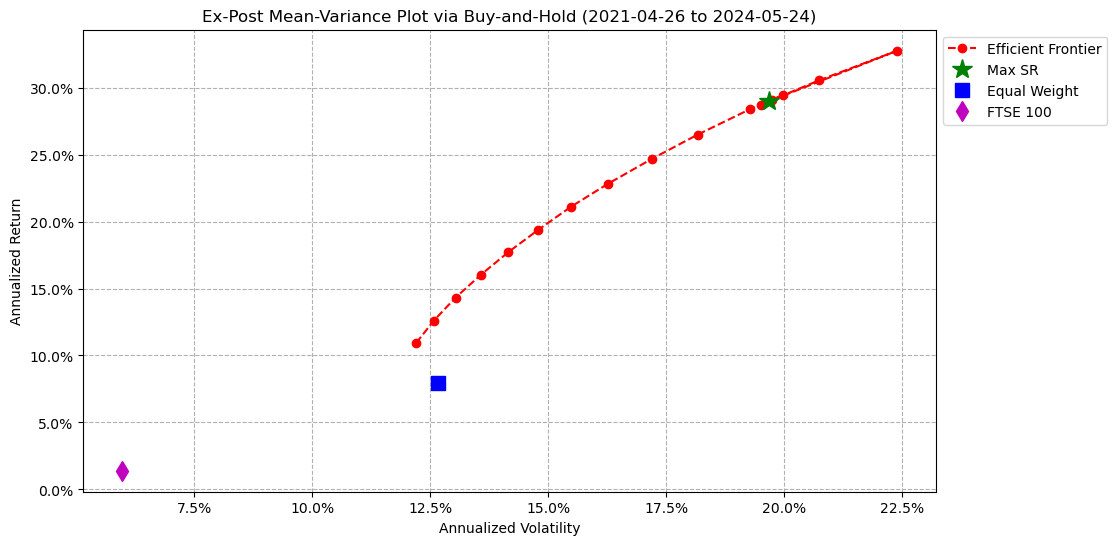

In [120]:
# Plotting Ex-Post efficient frontier and mark the various portfolios
plt.rcParams['figure.figsize'] = (11, 6)
# Plot efficient frontier
num_rbar = np.sum(PR_BH.columns.str.contains('%', case=False))
plt.plot(ann_std(PR_BH_std[:num_rbar]), ann_ret(PR_BH_mean[:num_rbar]), 'ro--' , label='Efficient Frontier')
# Plot optimal portfolio
plt.plot(ann_std(PR_BH_std['maxSR']), ann_ret(PR_BH_mean['maxSR']), 'g*', markersize=15, label='Max SR')
# Plot equal weighted portfolio
plt.plot(ann_std(PR_BH_std['Equal']), ann_ret(PR_BH_mean['Equal']), 'bs', markersize=10, label='Equal Weight')
# Plot FTSE 100 
plt.plot(ann_std(ftse100_BT.std()), ann_ret(ftse100_BT.mean()), 'md', markersize=10, label='FTSE 100')
# Customize the plot
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Ex-Post Mean-Variance Plot via Buy-and-Hold ('+str(start_date_train)+' to '+str(end_date_train)+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

## Step 11. Interpreting Output Recommendations <a id="11"></a>

Looking at the efficient frontier and its corresponding dataframe with asset allocations, we can clearly observe that:

- Portfolio on the top right end of efficient frontier consists of only three stocks

- Portfolio on the bottom left end of efficient frontier tend to be more conservative and with greater diversification

There is great advantage of solving Markowitz Problem IF we have excellent estimates of future performance – motivation to search for improving forecasts.

## Step 12. Future Direction <a id="12"></a>

There can be various enhancement that can be done - 

To calculation of the efficient frontier and optimal portfolio, for e.g 

1. We have taken simplest assets (Stock) instruments in the portfolio, however a investor may have different types of assets like bonds, options, structured product these can be modelled and then the two approaches of finding optimal portfolio can be compared. 

2. There are various ways (for e.g Modern Portfolio Theorey) that can be used to find optimal portfolio. MPT is the basic method. Advanced methods like Black Litterman can be modelled and optimized. 

Input Data:   

3. Web scraping can be used to get the data from uk.investing.com for different instruments that the user wants to incorporate

4. Data on various risk factors that influence returns can be integrated into the models as required.  

Visualization: 

5. The portfolio with equal distribution vs optimal distribution can be represented like a pie chart so that the effect of optimization of assets is made clear to the investor

## References <a id="13"></a>

1. [Modern Portfolio Theorey](https://en.wikipedia.org/wiki/Modern_portfolio_theory)
2. [Portfolio Optimization using MPT in Python](https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/)
3. [Sharpe Ratio](https://en.wikipedia.org/wiki/Sharpe_ratio)
4. [Scipi Minimize](https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.optimize.minimize.html)
5. [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization)
6. [Bayes Opt](https://github.com/rmcantin/bayesopt)
7. [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier)
8. [Efficient Frontier: What It Is and How Investors Use It](https://www.investopedia.com/terms/e/efficientfrontier.asp)